Global seed set to 42


##################################################
the data path: /workspace/data/split_pad_dataset_512/cord_test
ckpt: /workspace/project/logs/resnet/1119_1_8_resnet_depth50/flod2/checkpoints/epoch=11-val_loss=0.63-val_acc=0.8926.ckpt


Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main
Lightning automatically upgraded your loaded checkpoint from v1.8.1 to v1.9.5. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../logs/resnet/1119_1_8_resnet_depth50/flod2/checkpoints/epoch=11-val_loss=0.63-val_acc=0.8926.ckpt`
Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


##################################################
run pre process model! /workspace/data/split_pad_dataset_512/cord_test
##################################################
video_path: ['20171211_full_lat_49.mp4', '20171211_full_lat_49.mp4', '20171211_full_lat_175.mp4', '20171211_full_lat_175.mp4', '20171211_full_lat_127.mp4', '20171211_full_lat_127.mp4', 'ASD_not_val_0.mp4', 'ASD_not_val_0.mp4']
input_label: tensor([0, 0, 0, 0, 0, 0, 1, 1])
batch:0
input_tensor: torch.Size([1, 3, 8, 224, 224])


WARN:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


inp_tensor: float32


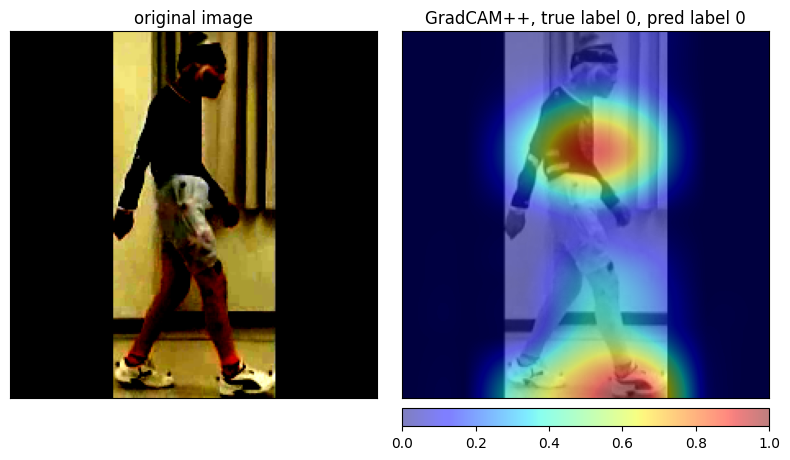

batch:1
input_tensor: torch.Size([1, 3, 8, 224, 224])


WARN:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


inp_tensor: float32


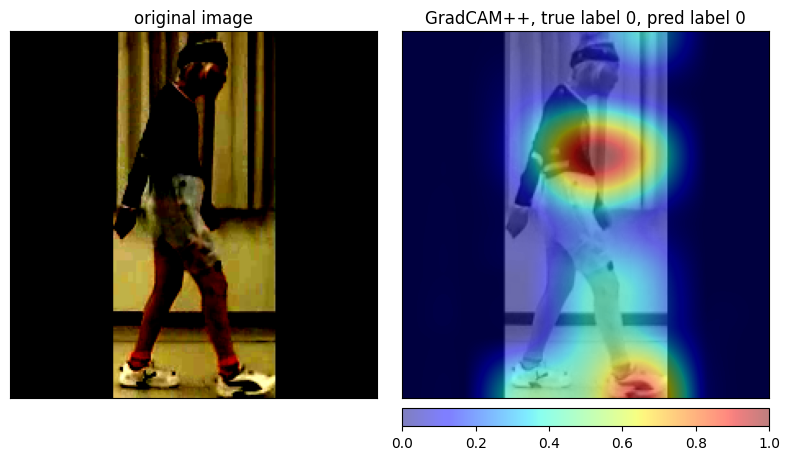

batch:2
input_tensor: torch.Size([1, 3, 8, 224, 224])


WARN:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


inp_tensor: float32


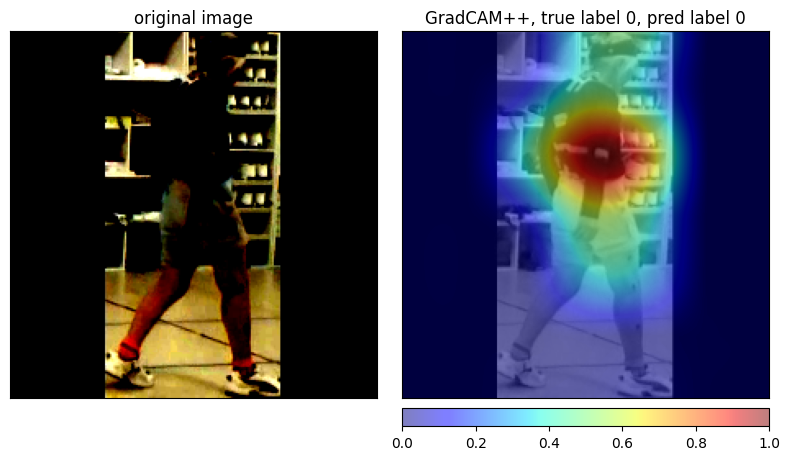

batch:3
input_tensor: torch.Size([1, 3, 8, 224, 224])


WARN:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


inp_tensor: float32


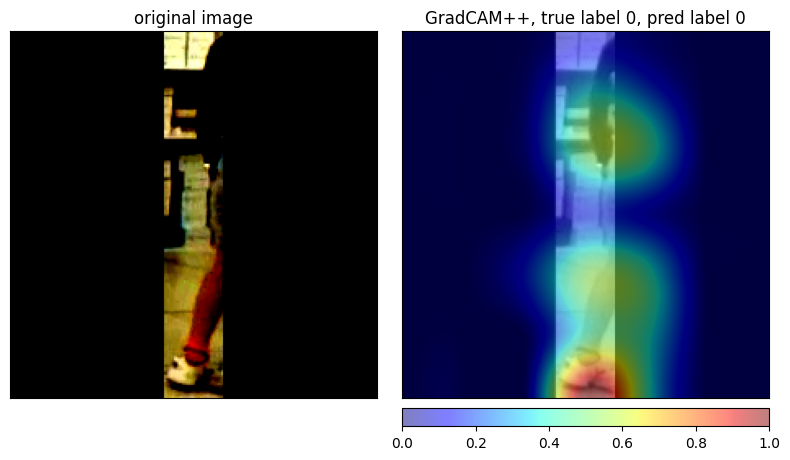

batch:4
input_tensor: torch.Size([1, 3, 8, 224, 224])


In [ ]:
import sys
import os 
import torch 
#print(os.getcwd())
from models.pytorchvideo_models import WalkVideoClassificationLightningModule
from dataloader.data_loader import WalkDataModule
from pytorch_lightning import Trainer
from IPython.display import clear_output
clear_output()
import torchmetrics
from pytorch_lightning import seed_everything
seed_everything(42, workers=True)
from parameters import get_parameters
from pytorch_grad_cam import GradCAM, HiResCAM, FullGrad, GradCAMPlusPlus, AblationCAM, ScoreCAM, LayerCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import torchvision
import cv2
from torchvision import models
from torchvision import transforms
from captum.attr import visualization as viz

os.environ['CUDA_VISIBLE_DEVICES'] = "1"
sys.path.append('..')
VIDEO_LENGTH = ['1', '2', '3']
VIDEO_FRAME = ['8', '16', '32']

opt, _ = get_parameters()
opt.num_workers = 4
opt.batch_size = 8
opt.gpu_num = 1

opt.version = '1201_1_16'
opt.model = "resnet"
opt.model_depth = 50
opt.model_class_num = 1

# opt.clip_duration = 2
# opt.uniform_temporal_subsample_num = 30
opt.version = opt.version + '_' + opt.model + '_depth' + str(opt.model_depth)

opt.fusion_method = 'slow_fusion'
opt.fix_layer = 'all'
# opt.train_path = '/workspace/data/split_pad_dataset_512/fold3/'

opt.transfor_learning = True
opt.pre_process_flag = True

DATA_PATH = opt.split_pad_data_path
opt.train_path = os.path.join(DATA_PATH, 'cord_test')

opt.clip_duration = int(1)
opt.uniform_temporal_subsample_num = int(8)

ckpt_path = '/workspace/project/logs/resnet/1119_1_8_resnet_depth50/flod2/checkpoints/epoch=11-val_loss=0.63-val_acc=0.8926.ckpt'

print('#' * 50)
print('the data path: %s' % opt.train_path)
print('ckpt: %s' % ckpt_path)
model = WalkVideoClassificationLightningModule(opt).load_from_checkpoint(ckpt_path)

data_module = WalkDataModule(opt)
data_module.setup()
test_data = data_module.val_dataloader()


#   {
#      'video': <video_tensor>,     # Shape: (C, T, H, W)
#      'audio': <audio_tensor>,     # Shape: (S)
#      'label': <action_label>,     # Integer defining class annotation
#      'video_name': <video_path>,  # Video file path stem
#      'video_index': <video_id>,   # index of video used by sampler
#      'clip_index': <clip_id>      # index of clip sampled within video
#   }
batch = next(iter(test_data))
video = batch['video'].detach() # b, c, t, h, w
label = batch['label'].detach() # b, class num
print("video_path:", batch['video_name'])
print("input_label:", batch['label'])



heatmap_out_dir = '/workspace/data/heatmap' 

# 作成するフォルダのパス
directories = [
    os.path.join(heatmap_out_dir, 'Success', 'pred_ASD_as_ASD'),
    os.path.join(heatmap_out_dir, 'Success', 'pred_ASDNot_as_ASDNot'),
    os.path.join(heatmap_out_dir, 'Failure', 'pred_ASD_as_ASDNot'),
    os.path.join(heatmap_out_dir, 'Failure', 'pred_ASDNot_as_ASD')
]

# フォルダを作成
for dir_path in directories:
    os.makedirs(dir_path, exist_ok=True)
    y_hat = model.model(video)

y_hat_sigmoid = torch.sigmoid(y_hat)
pred_label = torch.where(y_hat_sigmoid >= 0.5, torch.tensor(1), torch.tensor(0))

cam_map_list = []
for i in range(8):
    print('batch:'+str(i))
    input_tensor = video[i].unsqueeze(dim=0).cuda()
    print('input_tensor:', input_tensor.shape)
    inp_label = label[i]  
    # guided grad cam method
    target_layer = [model.model.blocks[-2].res_blocks[-1]]
    # target_layer = [ model.model.blocks[-2]]
    cam = LayerCAM(model, target_layer)
    
    out_label = pred_label[i]

    #print(pred_labels)
    #print(out_label)

    targets = [ClassifierOutputTarget(-1)]

    grayscale_cam = cam(input_tensor, aug_smooth=True, eigen_smooth=True)

    inp_tensor = input_tensor.squeeze().permute(1,2,3,0)[2].cpu().detach().numpy()
    print('inp_tensor:', inp_tensor.dtype)
    
    cam_map = grayscale_cam.mean(axis=1).squeeze()
    # cam_map = grayscale_cam[:,:,:,0].squeeze()
    cam_map = np.expand_dims(cam_map, 2)
    cam_map_list.append(cam_map)

        # use captum visual method
    figure, axis = viz.visualize_image_attr_multiple(
            cam_map,
            inp_tensor,
            methods=['original_image', 'blended_heat_map'],
            signs=['all', 'positive'],
            show_colorbar=True,
            outlier_perc=1, 
            cmap='jet',
            titles = ['original image', 'GradCAM++, true label %s, pred label %s' % (int(inp_label), int(out_label))]
        )

    
    # if int(inp_label) == int(out_label):
    #     if int(inp_label) == 0:
    #         save_path = heatmap_out_dir +  '/Success'+'/pred_ASD_as_ASD' + '/' batch['video_name'][i] + '.jpg'
    #         save_path.replace('.mp4', '')
    #         plt.savefig(save_path, bbox_inches='tight', pad_inches=0.5)
    #     elif int(inp_label) == 1:
    #         save_path = heatmap_out_dir +  '/Success/pred_ASDNot_as_ASDNot' +  batch['video_name'][i] + '.jpg'
    #         save_path.replace('.mp4', '')
    #         plt.savefig(save_path, bbox_inches='tight', pad_inches=0.5)
    # elif int(inp_label) != int(out_label):
    #     if int(inp_label) == 0:
    #         save_path = heatmap_out_dir +  '/Failure/pred_ASD_as_ASDNot' +  batch['video_name'][i] + '.jpg'
    #         save_path.replace('.mp4', '')
    #         plt.savefig(save_path, bbox_inches='tight', pad_inches=0.5)
    #     elif int(inp_label) == 1:
    #         save_path = heatmap_out_dir +  '/Failure/pred_ASDNot_as_ASD' +  batch['video_name'][i] + '.jpg'
    #         save_path.replace('.mp4', '')
    #         plt.savefig(save_path, bbox_inches='tight', pad_inches=0.5)
        

# # use captum visual method
# figure, axis = viz.visualize_image_attr_multiple(
#         cam_map_list[2],
#         inp_tensor,
#         methods=['original_image', 'blended_heat_map'],
#         signs=['all', 'positive'],
#         show_colorbar=True,
#         outlier_perc=1, 
#         cmap='jet',
#         titles = ['original image', 'GradCAM++, true label %s, pred label %s' % (int(inp_label), int(out_label))]
#     )



video.shape, label.shape, input_tensor.shape, inp_label, inp_tensor.shape

# Grad CAM pytorch
use pytorch_grad_cam api to make visilization.

In [34]:
from pytorch_grad_cam import GradCAM, HiResCAM, FullGrad, GradCAMPlusPlus, AblationCAM, ScoreCAM, LayerCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# guided grad cam method
target_layer = [model.model.blocks[-2].res_blocks[-1]]
# target_layer = [ model.model.blocks[-2]]

cam = LayerCAM(model, target_layer)
y_hat = model.model(video)
y_hat_sigmoid = torch.sigmoid(y_hat)
pred_labels = torch.where(y_hat_sigmoid >= 0.5, torch.tensor(1), torch.tensor(0))
print(pred_labels)
out_label = pred_labels[0]
print(out_label)

targets = [ClassifierOutputTarget(-1)]

grayscale_cam = cam(input_tensor, aug_smooth=True, eigen_smooth=True)



tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [1]])
tensor([0])


In [35]:
inp_tensor = input_tensor.squeeze().permute(1,2,3,0)[2].cpu().detach().numpy()
inp_tensor.shape, grayscale_cam.shape

((224, 224, 3), (1, 8, 224, 224))

In [36]:
cam_map = grayscale_cam.mean(axis=1).squeeze()
# cam_map = grayscale_cam[:,:,:,0].squeeze()
cam_map = np.expand_dims(cam_map, 2)

cam_map.shape, type(cam_map)

((224, 224, 1), numpy.ndarray)

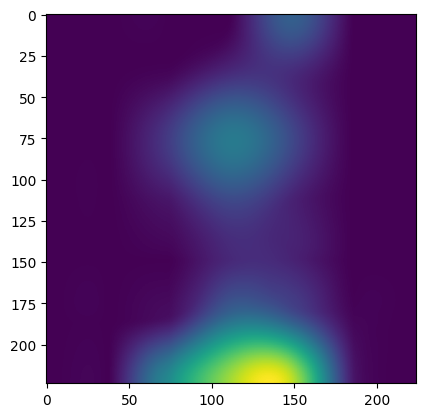

In [37]:
import matplotlib.pyplot as plt 

plt.imshow(cam_map)

WARN:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


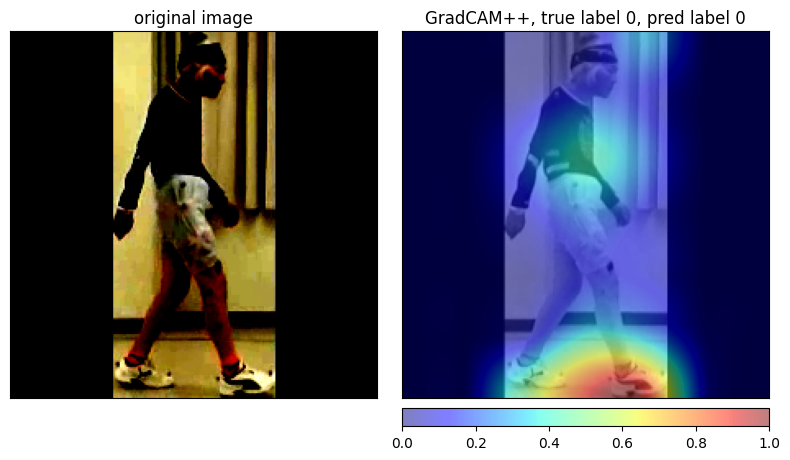

In [38]:
# use captum visual method
figure, axis = viz.visualize_image_attr_multiple(
        cam_map,
        inp_tensor,
        methods=['original_image', 'blended_heat_map'],
        signs=['all', 'positive'],
        show_colorbar=True,
        outlier_perc=1, 
        cmap='jet',
        titles = ['original image', 'GradCAM++, true label %s, pred label %s' % (int(inp_label), int(out_label))]
    )

In [39]:
input_tensor.shape

torch.Size([1, 3, 8, 224, 224])

In [40]:
from torchvision.io import write_video

write_video('1s.mp4', video_array=input_tensor.squeeze().permute(1,2,3,0).detach().cpu(), fps=10)

In [41]:
batch['video_name'][0]

'20171211_full_lat_49.mp4'